In [76]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import os
import seaborn as sns
sns.set_style('darkgrid')

In [4]:
pwd

'C:\\Users\\lenovo'

In [6]:
os.chdir('D:\\Masters Thesis\\Thesis Project')

In [10]:
df = pd.read_csv('airline_passengers.csv',index_col='Month',parse_dates=True)
df.index.freq = 'MS'

In [12]:
df.head()

,Thousands of Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


In [14]:
df.columns = ['Value']

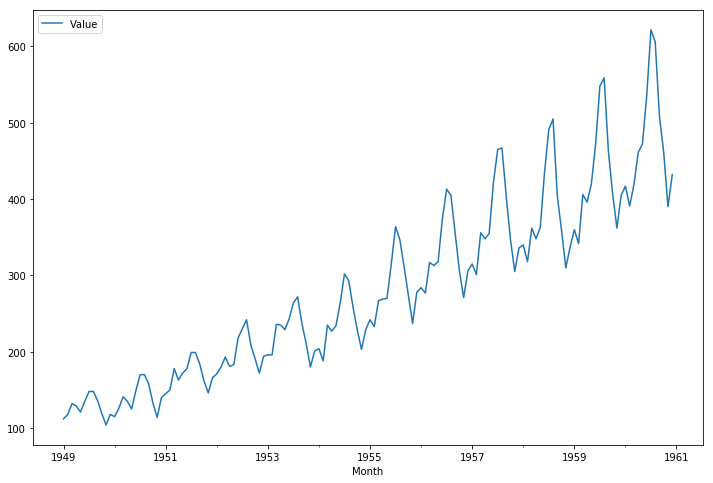

In [16]:
df.plot(figsize=(12,8))

In [19]:
from statsmodels.tsa.seasonal import seasonal_decompose

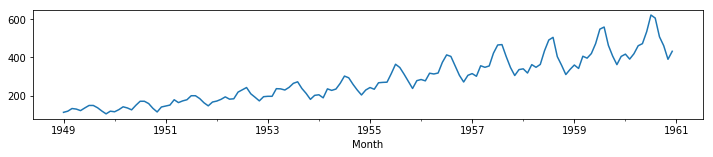

In [21]:
results = seasonal_decompose(df['Value'])
results.observed.plot(figsize=(12,2))

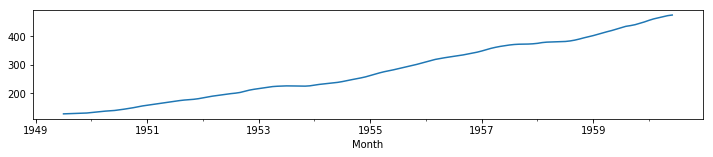

In [23]:
results.trend.plot(figsize=(12,2))

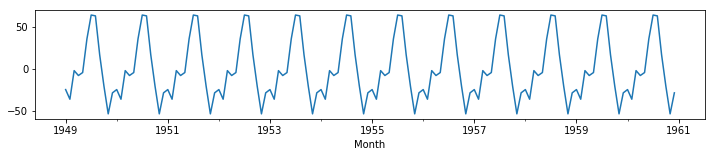

In [25]:
results.seasonal.plot(figsize=(12,2))

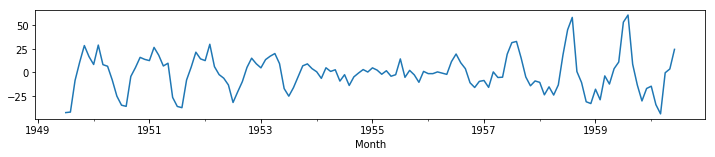

In [27]:
results.resid.plot(figsize=(12,2))

In [29]:
len(df)

144

In [31]:
train_len = len(df)-12

In [33]:
train = df.iloc[:train_len]
test = df.iloc[train_len:]

In [35]:
len(test)

12

In [37]:
from sklearn.preprocessing import MinMaxScaler

In [39]:
scaler = MinMaxScaler()

In [41]:
scaler.fit(train)

MinMaxScaler(copy=True, feature_range=(0, 1))

In [43]:
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

In [45]:
from keras.preprocessing.sequence import TimeseriesGenerator

In [47]:
n_input = 24
n_features=1
generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)

In [49]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

In [51]:
model = Sequential()
model.add(LSTM(150, activation='relu', input_shape=(n_input, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [53]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 150)               91200     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 151       
Total params: 91,351
Trainable params: 91,351
Non-trainable params: 0
_________________________________________________________________


In [55]:
model.fit_generator(generator,epochs=30)

Epoch 1/30
108/108 [==============================] - 2s 14ms/step - loss: 0.0028
Epoch 2/30
108/108 [==============================] - 2s 14ms/step - loss: 0.0020
Epoch 3/30
108/108 [==============================] - 2s 17ms/step - loss: 0.0028
Epoch 4/30
108/108 [==============================] - 1s 14ms/step - loss: 0.0026
Epoch 5/30
108/108 [==============================] - 2s 14ms/step - loss: 0.0017
Epoch 6/30
108/108 [==============================] - 2s 14ms/step - loss: 0.0017
Epoch 7/30
108/108 [==============================] - 1s 13ms/step - loss: 0.0018
Epoch 8/30
108/108 [==============================] - 1s 14ms/step - loss: 0.0021
Epoch 9/30
108/108 [==============================] - 1s 14ms/step - loss: 0.0017
Epoch 10/30
108/108 [==============================] - 2s 14ms/step - loss: 0.0017
Epoch 11/30
108/108 [==============================] - 1s 13ms/step - loss: 0.0015
Epoch 12/30
108/108 [==============================] - 1s 13ms/step - loss: 0.0016
Epoch 13/30
1

In [57]:
model.history.history.keys()

dict_keys(['loss'])

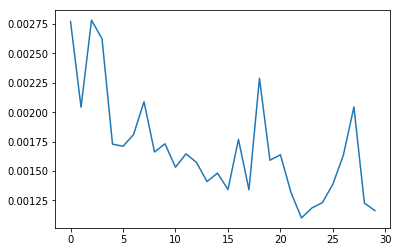

In [59]:
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

In [61]:
first_eval_batch = scaled_train[-12:]

In [63]:
first_eval_batch

array([[0.56263736],
       [0.52307692],
       [0.66373626],
       [0.64175824],
       [0.69450549],
       [0.80879121],
       [0.97582418],
       [1.        ],
       [0.78901099],
       [0.66593407],
       [0.56703297],
       [0.66153846]])

In [65]:
test_predictions = []

first_eval_batch = scaled_train[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(len(test)):
    
    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = model.predict(current_batch)[0]
    
    # store prediction
    test_predictions.append(current_pred) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

In [67]:
true_predictions = scaler.inverse_transform(test_predictions)

In [69]:
true_predictions

array([[387.71419132],
       [379.5428198 ],
       [398.69116569],
       [404.93874484],
       [429.39729029],
       [490.03509754],
       [561.62815595],
       [607.16928089],
       [504.94150513],
       [409.08150488],
       [354.79406202],
       [371.27042586]])

In [71]:
test['Predictions'] = true_predictions

C:\Users\lenovo\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [73]:
test

,Value,Predictions
Month,,
1960-01-01,417,387.714191
1960-02-01,391,379.542820
1960-03-01,419,398.691166
1960-04-01,461,404.938745
1960-05-01,472,429.397290
1960-06-01,535,490.035098
1960-07-01,622,561.628156
1960-08-01,606,607.169281
1960-09-01,508,504.941505


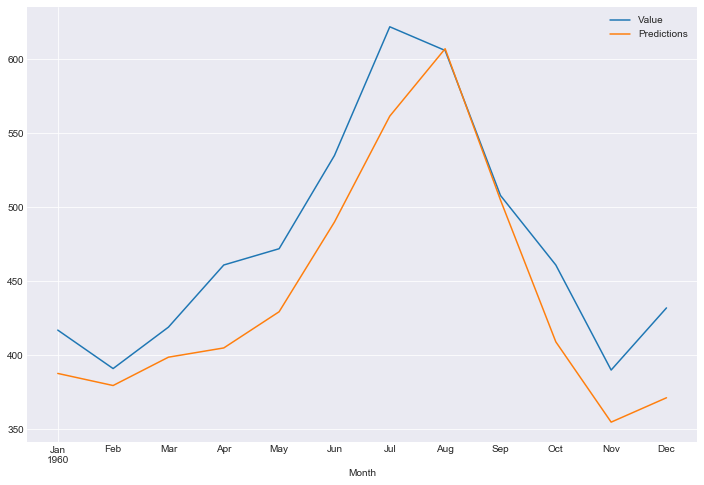

In [82]:
test.plot(figsize=(12,8))